# Multi-class Classification of Anonymized Datasets

k-anonymity is a property of a dataset that the information for each entry can not be distinguished from at least k-1 other entries in the dataset. As it can significantly change the appereance of the dataset, it also affects the performance of classification tasks on the dataset. The anonymity of the dataset is obtained by generalization of the attributes, therefore the bigger the k, the worst we expect the results of a classification to be. The aim of this notebook is to show the differences in performance of classification tasks on non-anonymous and anonymous dataset with different degrees of anonymity.

In our experiments the algorithm used to obtain k-anonymity of the 'Adult' dataset is SaNGreeA - a version of a greedy clustering algorithm. We anonymize the dataset with 10 different degrees of anonymity (k value): 3, 7, 11, 15, 19, 23, 27, 31, 35, 100.

The classification task is predicting the 'marital-status' attribute. For the classification we use 4 classifiers:
<ol>
    <li>Logistic Regression</li>
    <li>Linear Support Vector Classification</li>
    <li>Random Forest</li>
    <li>Gradient Boosting</li>
</ol>

In [1]:
# The whole multi-class classification on target 'marital-status' on the adult dataset under several degrees of k-anonymization
# k = {(1), 3, 7, 11, 15, 19, 23, 27, 31, 35, 100}
# classifiers: Logistic Regression, Linear SVC, Random Forest, Gradient Boosting

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import pickle

from sklearn import metrics, preprocessing, model_selection
from sklearn.ensemble import GradientBoostingClassifier as GradientBoosting, RandomForestClassifier as RandomForest
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

c:\users\tsarcevic\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Reading data
def read_data(filepath):
    #filepath = "../data/adult_all.csv"
    dataset = pd.read_csv(filepath, sep=r'\s*,\s*', na_values="*", engine='python', index_col=0)
    return dataset

In [4]:
# Reading anonymized data
def read_anon_data(filename):
    filepath = "../output/marital-status/"
    filepath += filename
    dataset = pd.read_csv(filepath, sep=r'\s*,\s*', na_values="*", engine='python', index_col=False)
    return dataset

In [5]:
# Preprocessing
def number_encode_features(ds):
    result = ds.copy()
    encoders = {}
    for feature in result.columns:
        if result.dtypes[feature] == np.object:
            encoders[feature] = preprocessing.LabelEncoder()
            result[feature] = encoders[feature].fit_transform(result[feature].astype(str))
    return result, encoders

In [6]:
# Scoring
def f1_micro(clf, X, y):
    # cross validation scores on number encoded data
    scores = model_selection.cross_val_score(clf, X, y, cv=10, scoring='f1_micro')
    print("F1 score: %0.2f (+/- %0.2f)" 
          % (scores.mean(), scores.std() * 2))
    return scores.mean()

In [7]:
k_values = 1, 3, 7, 11, 15, 19, 23, 27, 31, 35, 100

f1_scores_GB = []
f1_scores_LR = []
f1_scores_LSVC = []
f1_scores_RF = []

In [8]:
def run_classifications():
    for k in k_values:
        # read data
        if k==1:
            dataset = read_data("../data/adult_all.csv")
        else:
            dataset = read_anon_data("anonymized_equal_weights_k_" + str(k) + ".csv")

        # preprocess for Random Forest and Gradient Boosting
        dataset_encoded, encoders = number_encode_features(dataset)
        # define features and target 'marital-status'
        y_enc = dataset_encoded['marital-status']
        X_enc = dataset_encoded.drop('marital-status', axis=1)

        #preprocess for Logistic Regression and Linear SVC
        y_bin = dataset['marital-status']
        X_bin = dataset.drop('marital-status', axis=1)
        X_bin = pd.get_dummies(X_bin)
        if k==1:
            del X_bin['sex_Male'], X_bin['income_>50K'], X_bin['native-country_Non-US']


        # define classifiers
        clf_GB = GradientBoosting(random_state=0)
        clf_LR = LogisticRegression(random_state=0)
        clf_LSVC = LinearSVC(random_state=0)
        clf_RF = RandomForest(random_state=0)

        # scoring
        f1_scores_GB.append(f1_micro(clf_GB, X_enc, y_enc))
        if k==1:
            f1_scores_LR.append(f1_micro(clf_LR, X_bin, y_bin))
        else:
            f1_scores_LR.append(f1_micro(clf_LR, X_enc, y_enc))
        f1_scores_LSVC.append(f1_micro(clf_LSVC, X_bin, y_bin))
        f1_scores_RF.append(f1_micro(clf_RF, X_enc, y_enc))

In [9]:
#run_classifications()

In [10]:
# loading previously obtained results to avoid running the big loop from above
def load_classification_results():
    for k in k_values:
        # load results
        if k==1:
            infile = open('../output/marital-status/classification-res/adult_multiclass_full', 'rb')
        else:
            infile = open('../output/marital-status/classification-res/adult_multiclass_k' + str(k), 'rb')
        scores = pickle.load(infile)
        infile.close()

        f1_scores_GB.append(scores['Gradient Boosting'])
        f1_scores_LR.append(scores['Logistic Regression'])
        f1_scores_LSVC.append(scores['Linear SVC'])
        f1_scores_RF.append(scores['Random Forest'])

In [11]:
load_classification_results()

In [12]:
# Visualize
def plot_results():
    ticks = (-1,) + k_values[1:-1] + (39,)
    xlabels = list(k_values); xlabels[0] = "None"
    
    fig = plt.figure(figsize=(14.56,9))
    ax = fig.add_subplot(2,2,1)
    ax.set_title('Logistic Regression')
    ax.set_xticklabels(xlabels)
    
    plt.plot(ticks, f1_scores_LR, marker='o')
    plt.ylabel('f1 score')
    plt.xlabel('k')
    plt.xticks(ticks)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('Linear SVC')
    ax.set_xticklabels(xlabels)

    plt.plot(ticks, f1_scores_LSVC, marker='o')
    plt.ylabel('f1 score')
    plt.xlabel('k')
    plt.xticks(ticks)

    ax = fig.add_subplot(2,2,3)
    ax.set_title('Random Forest')
    ax.set_xticklabels(xlabels)

    plt.plot(ticks, f1_scores_RF, marker='o')
    plt.ylabel('f1 score')
    plt.xlabel('k')
    plt.xticks(ticks)

    ax = fig.add_subplot(2,2,4)
    ax.set_title('Gradient Boosting')
    ax.set_xticklabels(xlabels)

    plt.plot(ticks, f1_scores_GB, marker='o')
    plt.ylabel('f1 score')
    plt.xlabel('k')
    plt.xticks(ticks)

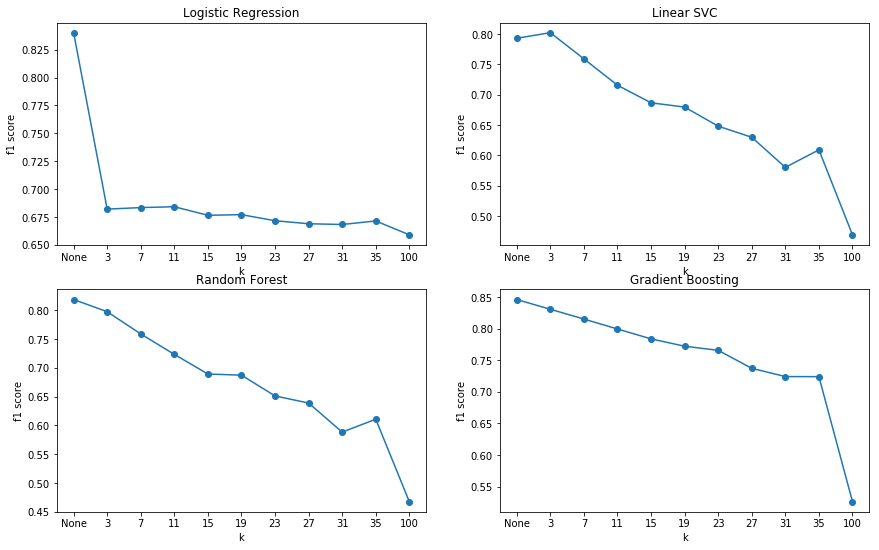

In [13]:
plot_results()